## import

In [20]:
from pathlib import Path

import matplotlib.pyplot as plt
import albumentations as A
import torch
import torch.nn.functional as F
import torchinfo
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import DataLoader
from torchlake.common.constants import VOC_CLASS_NAMES
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.image import decode_segmap, load_image, overlay_image
from torchlake.common.utils.plot import plot_grids
from torchlake.common.utils.platform import get_file_size, get_num_workers

from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.datasets.voc import VOCSegmentation
from torchlake.common.datasets.voc.constants import LABEL_COLORS
from torchlake.semantic_segmentation.models.r_aspp import r_aspp_style_mobilenet
from torchlake.semantic_segmentation.models.lr_aspp import MobileNetV3Seg

from tqdm import tqdm

# setting

In [2]:
artifacts_path = Path("../../artifacts/mobilenetv3-lraspp")
artifacts_path.mkdir(exist_ok=True)

data_path = Path("../../data")

In [3]:
DEVICE = torch.device("cuda:0")

# data

In [4]:
# FACTOR: int = 2
# BATCH_SIZE = 4 * (2 * FACTOR if FACTOR > 1 else FACTOR)
# TRAIN_IMAGE_SIZE = (1024 //FACTOR, 2048 // FACTOR)
# TEST_IMAGE_SIZE = (1024 // FACTOR, 2048 // FACTOR)
BATCH_SIZE = 8
TRAIN_IMAGE_SIZE = 512
TEST_IMAGE_SIZE = 512
NUM_CLASS = len(VOC_CLASS_NAMES)

In [5]:
train_transform = A.Compose(
    [
        A.HorizontalFlip(),
        A.Resize(TRAIN_IMAGE_SIZE, TRAIN_IMAGE_SIZE),
        # A.Resize(*TRAIN_IMAGE_SIZE),
        A.Normalize(0, 1),  # in feature extractor
        ToTensorV2(),
    ]
)

test_transform = A.Compose(
    [
        A.Resize(TEST_IMAGE_SIZE, TEST_IMAGE_SIZE),
        # A.Resize(*TEST_IMAGE_SIZE),
        A.Normalize(0, 1),  # in feature extractor
        ToTensorV2(),
    ]
)

In [6]:
train_dataset = VOCSegmentation(
    data_path.as_posix(),
    year="2012",
    transform=train_transform,
)

test_dataset = VOCSegmentation(
    data_path.as_posix(),
    year="2007",
    transform=test_transform,
)

In [7]:
NUM_WORKERS = get_num_workers()

In [8]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=NUM_WORKERS,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
)

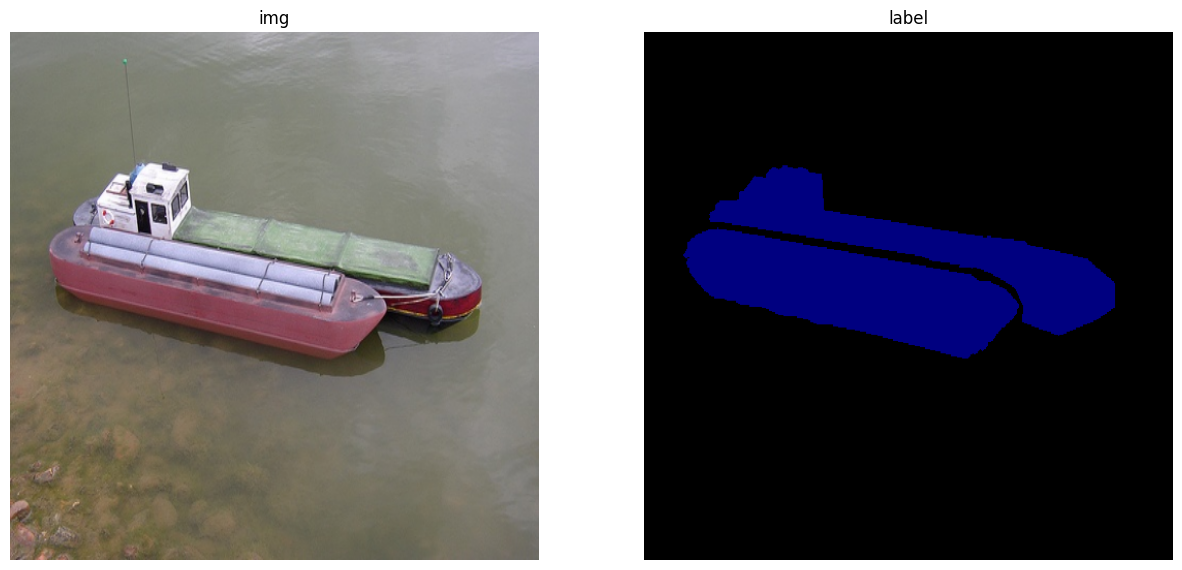

In [9]:
interest_pic = 102
img, label = train_dataset[interest_pic]

plot_grids(
    [
        img_tensor_to_np(img),
        decode_segmap(label, LABEL_COLORS),
    ],
    ["img", "label"],
    1,
    2,
    figsize=(15, 7),
)

In [10]:
row = next(iter(train_loader))
for ele in row: print(ele.shape)

torch.Size([8, 3, 512, 512])
torch.Size([8, 512, 512])


# model

In [11]:

backbone = r_aspp_style_mobilenet("mobilenet_v3_large", trainable=True, dilation_size_16x=1, dilation_size_32x=2)
model = MobileNetV3Seg(
    backbone,
    NUM_CLASS + 1,
    # no effect, since mobile v3 is narrow
    hidden_dim=128,
    # pool parameters are optional, you can use default value
    # if use default, image size should be 1024 x 2048
    # formula is in LR-ASPP module source code
    # pool_kernel_size=(17, 17),
    # pool_stride=(16, 12),
    pool_kernel_size=(32, 32),
    pool_stride=(16, 16),
).to(DEVICE)

In [12]:
torchinfo.summary(model)

Layer (type:depth-idx)                                  Param #
MobileNetV3Seg                                          --
├─MobileNetFeatureExtractor: 1-1                        --
│    └─Sequential: 2-1                                  --
│    │    └─Conv2dNormActivation: 3-1                   464
│    │    └─InvertedResidual: 3-2                       464
│    │    └─InvertedResidual: 3-3                       3,440
│    │    └─InvertedResidual: 3-4                       4,440
│    │    └─InvertedResidual: 3-5                       10,328
│    │    └─InvertedResidual: 3-6                       20,992
│    │    └─InvertedResidual: 3-7                       20,992
│    │    └─InvertedResidual: 3-8                       32,080
│    │    └─InvertedResidual: 3-9                       34,760
│    │    └─InvertedResidual: 3-10                      31,992
│    │    └─InvertedResidual: 3-11                      31,992
│    │    └─InvertedResidual: 3-12                      214,424
│    │    

# train

In [13]:
EPOCHS = 30

In [14]:
trainer = ClassificationTrainer(EPOCHS, DEVICE)
trainer.recorder.increment_data_size(len(train_dataset))

In [15]:
criterion = trainer.get_criterion(NUM_CLASS)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [16]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, threshold=.05 ,threshold_mode ='rel')

In [17]:
training_loss = trainer.run(train_loader, model, optimizer, criterion, scheduler)

Enable AMP: False
Training...


100%|██████████| 364/364 [04:08<00:00,  1.46it/s]


------------------------------------
Epoch 1
------------------------------------
total: 3.1329e-01 (0.00%)


100%|██████████| 364/364 [00:59<00:00,  6.14it/s]


------------------------------------
Epoch 2
------------------------------------
total: 1.2837e-01 (-59.00%)


100%|██████████| 364/364 [00:56<00:00,  6.50it/s]


------------------------------------
Epoch 3
------------------------------------
total: 9.8672e-02 (-23.00%)


100%|██████████| 364/364 [00:59<00:00,  6.14it/s]


------------------------------------
Epoch 4
------------------------------------
total: 7.9743e-02 (-19.00%)


100%|██████████| 364/364 [00:59<00:00,  6.10it/s]


------------------------------------
Epoch 5
------------------------------------
total: 6.7516e-02 (-15.00%)


100%|██████████| 364/364 [00:59<00:00,  6.12it/s]


------------------------------------
Epoch 6
------------------------------------
total: 5.7908e-02 (-14.00%)


100%|██████████| 364/364 [00:58<00:00,  6.25it/s]


------------------------------------
Epoch 7
------------------------------------
total: 5.1232e-02 (-12.00%)


100%|██████████| 364/364 [00:59<00:00,  6.14it/s]


------------------------------------
Epoch 8
------------------------------------
total: 4.5934e-02 (-10.00%)


100%|██████████| 364/364 [00:58<00:00,  6.23it/s]


------------------------------------
Epoch 9
------------------------------------
total: 4.0618e-02 (-12.00%)


100%|██████████| 364/364 [00:59<00:00,  6.10it/s]


------------------------------------
Epoch 10
------------------------------------
total: 3.7066e-02 (-9.00%)


100%|██████████| 364/364 [01:01<00:00,  5.96it/s]


------------------------------------
Epoch 11
------------------------------------
total: 3.4096e-02 (-8.00%)


100%|██████████| 364/364 [00:59<00:00,  6.13it/s]


------------------------------------
Epoch 12
------------------------------------
total: 3.2290e-02 (-5.00%)


100%|██████████| 364/364 [00:55<00:00,  6.61it/s]


------------------------------------
Epoch 13
------------------------------------
total: 2.9290e-02 (-9.00%)


100%|██████████| 364/364 [00:58<00:00,  6.23it/s]


------------------------------------
Epoch 14
------------------------------------
total: 2.8392e-02 (-3.00%)


100%|██████████| 364/364 [00:58<00:00,  6.19it/s]


------------------------------------
Epoch 15
------------------------------------
total: 2.6015e-02 (-8.00%)


100%|██████████| 364/364 [00:58<00:00,  6.26it/s]


------------------------------------
Epoch 16
------------------------------------
total: 2.5371e-02 (-2.00%)


100%|██████████| 364/364 [00:57<00:00,  6.29it/s]


------------------------------------
Epoch 17
------------------------------------
total: 2.3852e-02 (-6.00%)


100%|██████████| 364/364 [00:59<00:00,  6.16it/s]


------------------------------------
Epoch 18
------------------------------------
total: 2.2026e-02 (-8.00%)


100%|██████████| 364/364 [01:01<00:00,  5.95it/s]


------------------------------------
Epoch 19
------------------------------------
total: 2.1008e-02 (-5.00%)


100%|██████████| 364/364 [00:59<00:00,  6.10it/s]


------------------------------------
Epoch 20
------------------------------------
total: 2.1234e-02 (1.00%)


100%|██████████| 364/364 [01:00<00:00,  6.02it/s]


------------------------------------
Epoch 21
------------------------------------
total: 2.0479e-02 (-4.00%)


100%|██████████| 364/364 [00:58<00:00,  6.18it/s]


------------------------------------
Epoch 22
------------------------------------
total: 1.9332e-02 (-6.00%)


100%|██████████| 364/364 [00:58<00:00,  6.22it/s]


------------------------------------
Epoch 23
------------------------------------
total: 1.8741e-02 (-3.00%)


100%|██████████| 364/364 [00:58<00:00,  6.22it/s]


------------------------------------
Epoch 24
------------------------------------
total: 1.8147e-02 (-3.00%)


100%|██████████| 364/364 [00:54<00:00,  6.70it/s]


------------------------------------
Epoch 25
------------------------------------
total: 1.8093e-02 (0.00%)


100%|██████████| 364/364 [00:47<00:00,  7.66it/s]


------------------------------------
Epoch 26
------------------------------------
total: 1.7167e-02 (-5.00%)


100%|██████████| 364/364 [00:58<00:00,  6.24it/s]


------------------------------------
Epoch 27
------------------------------------
total: 1.6632e-02 (-3.00%)


100%|██████████| 364/364 [00:59<00:00,  6.10it/s]


------------------------------------
Epoch 28
------------------------------------
total: 1.6057e-02 (-3.00%)


100%|██████████| 364/364 [01:00<00:00,  6.02it/s]


------------------------------------
Epoch 29
------------------------------------
total: 1.5315e-02 (-5.00%)


100%|██████████| 364/364 [01:04<00:00,  5.61it/s]

------------------------------------
Epoch 30
------------------------------------
total: 1.6436e-02 (7.00%)


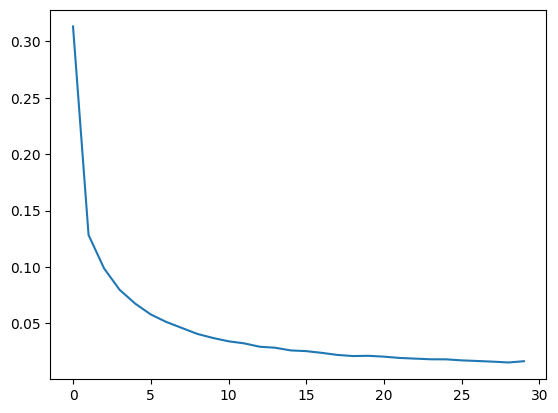

In [18]:
plt.plot(training_loss)

In [27]:
model_path = artifacts_path.joinpath('lraspp.mobilenetv3.pth')

In [28]:
torch.save(model.state_dict(), model_path)

In [29]:
get_file_size(model_path)

'11.72MiB'

In [30]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

# inference

### mIOU

In [19]:
from torchmetrics.classification import jaccard

metric = jaccard.MulticlassJaccardIndex(NUM_CLASS + 1, average=None)

In [21]:
evaluator = ClassificationEvaluator(NUM_CLASS+1, DEVICE)

In [22]:
metric = evaluator.run(test_loader, model, metric)

100%|██████████| 79/79 [00:42<00:00,  1.85it/s]


In [23]:
for class_name, value in zip(VOC_CLASS_NAMES, metric.compute()[1:].mul(100).round().tolist()):
    print("{:<15}: {:<5}".format(class_name, value / 100))

print("----------------------")
print("{:<15}: {:<5}".format("total", metric.compute()[1:].mean().mul(100).round().item()/100))

aeroplane      : 0.84 
bicycle        : 0.5  
bird           : 0.88 
boat           : 0.81 
bottle         : 0.82 
bus            : 0.92 
car            : 0.83 
cat            : 0.92 
chair          : 0.6  
cow            : 0.85 
diningtable    : 0.85 
dog            : 0.85 
horse          : 0.76 
motorbike      : 0.8  
person         : 0.83 
pottedplant    : 0.54 
sheep          : 0.84 
sofa           : 0.8  
train          : 0.91 
tvmonitor      : 0.73 
----------------------
total          : 0.79 


(<Figure size 640x480 with 1 Axes>, <Axes: ylabel='MulticlassJaccardIndex'>)

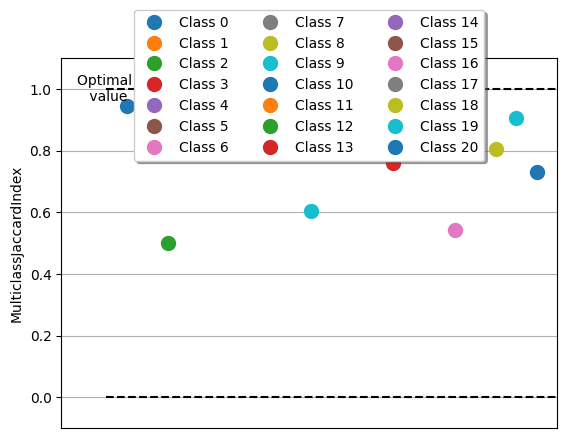

In [24]:
metric.plot()

### for image in dataset

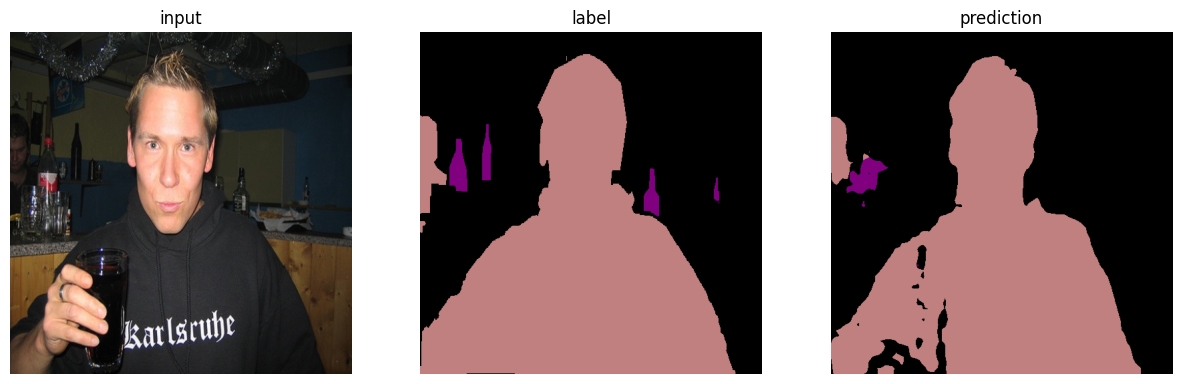

In [25]:
interest_pic = 10

model.eval()
with torch.no_grad():
    target_img, target_label = test_dataset[interest_pic]

    output = model(target_img.unsqueeze(0).to(DEVICE))
    output = output.squeeze(0).permute(1, 2, 0).argmax(dim=2).detach().cpu()

plot_grids(
    [
        img_tensor_to_np(target_img),
        decode_segmap(target_label.numpy(), LABEL_COLORS),
        decode_segmap(output.numpy(), LABEL_COLORS),
    ],
    ["input", "label", "prediction"],
    1,
    3,
    figsize=(15, 15),
)

### for any image

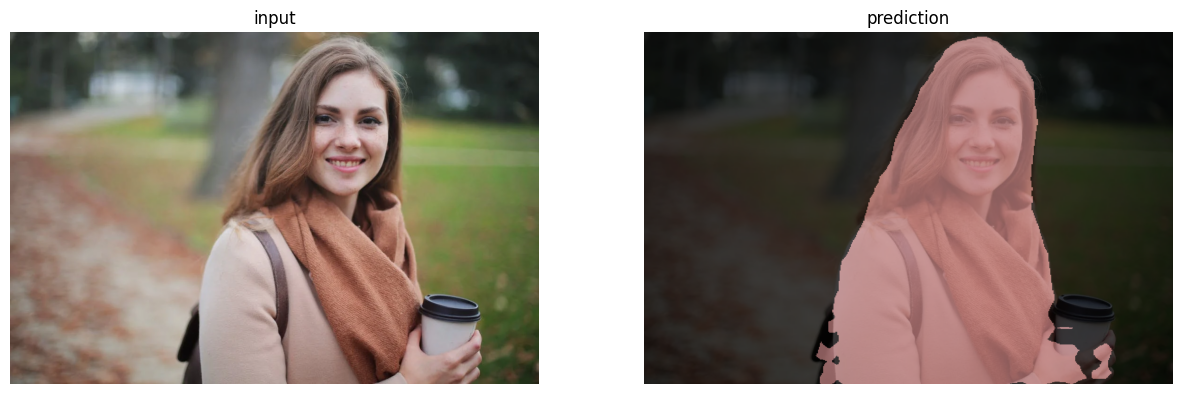

In [26]:
model.eval()
with torch.no_grad():
    target_img = load_image(data_path.joinpath("person.webp"), is_numpy=True)

    h, w, c = target_img.shape
    test_img = test_transform(image=target_img)["image"]
    output = model(test_img.unsqueeze(0).to(DEVICE))
    output = output.argmax(dim=1, keepdim=True)
    # B, C, H, W
    output = F.interpolate(output.float(), size=(h, w), mode="nearest")
    # 1, 1, h, w
    output = output.squeeze(0, 1).detach().cpu().numpy()

coef = 0.7
mask = decode_segmap(output, LABEL_COLORS)
overlaid = overlay_image(target_img, mask, coef)

plot_grids(
    [
        target_img,
        overlaid,
    ],
    ["input", "prediction"],
    1,
    2,
    figsize=(15, 15),
)